In [1]:
import pandas as pd
import sqlite3
import json
import matplotlib.pyplot as plt
import seaborn as sns

con = sqlite3.connect("travel.sqlite")

In [2]:
%load_ext sql

In [3]:
%sql sqlite:///travel.sqlite

In [4]:
#database schema 
%sql SELECT * FROM sqlite_master where type='table';

 * sqlite:///travel.sqlite
Done.


type,name,tbl_name,rootpage,sql
table,aircrafts_data,aircrafts_data,2,"CREATE TABLE aircrafts_data ( aircraft_code character(3) NOT NULL, model jsonb NOT NULL, range integer NOT NULL, CONSTRAINT aircrafts_range_check CHECK ((range > 0)) )"
table,airports_data,airports_data,3,"CREATE TABLE airports_data ( airport_code character(3) NOT NULL, airport_name jsonb NOT NULL, city jsonb NOT NULL, coordinates point NOT NULL, timezone text NOT NULL )"
table,boarding_passes,boarding_passes,4,"CREATE TABLE boarding_passes ( ticket_no character(13) NOT NULL, flight_id integer NOT NULL, boarding_no integer NOT NULL, seat_no character varying(4) NOT NULL )"
table,bookings,bookings,5,"CREATE TABLE bookings ( book_ref character(6) NOT NULL, book_date timestamp with time zone NOT NULL, total_amount numeric(10,2) NOT NULL )"
table,flights,flights,6,"CREATE TABLE flights ( flight_id integer NOT NULL, flight_no character(6) NOT NULL, scheduled_departure timestamp with time zone NOT NULL, scheduled_arrival timestamp with time zone NOT NULL, departure_airport character(3) NOT NULL, arrival_airport character(3) NOT NULL, status character varying(20) NOT NULL, aircraft_code character(3) NOT NULL, actual_departure timestamp with time zone, actual_arrival timestamp with time zone )"
table,seats,seats,7,"CREATE TABLE seats ( aircraft_code character(3) NOT NULL, seat_no character varying(4) NOT NULL, fare_conditions character varying(10) NOT NULL )"
table,ticket_flights,ticket_flights,8,"CREATE TABLE ticket_flights ( ticket_no character(13) NOT NULL, flight_id integer NOT NULL, fare_conditions character varying(10) NOT NULL, amount numeric(10,2) NOT NULL )"
table,tickets,tickets,9,"CREATE TABLE tickets ( ticket_no character(13) NOT NULL, book_ref character(6) NOT NULL, passenger_id character varying(20) NOT NULL)"


In [7]:
#I am going to extract names of English version airports and cities, coordinates will be sepertated later in this code
%sql select * from airports_data limit 3

 * sqlite:///travel.sqlite
Done.


airport_code,airport_name,city,coordinates,timezone
YKS,"{""en"": ""Yakutsk Airport"", ""ru"": ""Якутск""}","{""en"": ""Yakutsk"", ""ru"": ""Якутск""}","(129.77099609375,62.0932998657226562)",Asia/Yakutsk
MJZ,"{""en"": ""Mirny Airport"", ""ru"": ""Мирный""}","{""en"": ""Mirnyj"", ""ru"": ""Мирный""}","(114.03900146484375,62.534698486328125)",Asia/Yakutsk
KHV,"{""en"": ""Khabarovsk-Novy Airport"", ""ru"": ""Хабаровск-Новый""}","{""en"": ""Khabarovsk"", ""ru"": ""Хабаровск""}","(135.18800354004,48.5279998779300001)",Asia/Vladivostok


In [8]:
#Implementation of extracting data from airports_data table
query = pd.read_sql('select * from airports_data',con)
query['airport_name']= [items[8:items.find('",')] for items in query['airport_name']]
query['city']= [items[8:items.find('",')] for items in query['city']]
query.to_sql('airports_data', con, if_exists='replace', index=False)
pd.read_sql('select * from airports_data limit 5',con)

,airport_code,airport_name,city,coordinates,timezone
0,YKS,Yakutsk Airport,Yakutsk,"(129.77099609375,62.0932998657226562)",Asia/Yakutsk
1,MJZ,Mirny Airport,Mirnyj,"(114.03900146484375,62.534698486328125)",Asia/Yakutsk
2,KHV,Khabarovsk-Novy Airport,Khabarovsk,"(135.18800354004,48.5279998779300001)",Asia/Vladivostok
3,PKC,Yelizovo Airport,Petropavlovsk,"(158.453994750976562,53.1679000854492188)",Asia/Kamchatka
4,UUS,Yuzhno-Sakhalinsk Airport,Yuzhno-Sakhalinsk,"(142.718002319335938,46.8886985778808594)",Asia/Sakhalin


In [9]:
#Extracting of English version of models is needed, I'll aply the same way to do it
%sql select * from aircrafts_data limit 5

 * sqlite:///travel.sqlite
Done.


aircraft_code,model,range
773,"{""en"": ""Boeing 777-300"", ""ru"": ""Боинг 777-300""}",11100
763,"{""en"": ""Boeing 767-300"", ""ru"": ""Боинг 767-300""}",7900
SU9,"{""en"": ""Sukhoi Superjet-100"", ""ru"": ""Сухой Суперджет-100""}",3000
320,"{""en"": ""Airbus A320-200"", ""ru"": ""Аэробус A320-200""}",5700
321,"{""en"": ""Airbus A321-200"", ""ru"": ""Аэробус A321-200""}",5600


In [10]:
#Implementation
data = pd.read_sql('select * from aircrafts_data',con)
data['model']= [items[8:items.find('",')] for items in data['model']]
data.to_sql('aircrafts_data', con, if_exists='replace', index=False)
pd.read_sql('select * from aircrafts_data',con)

,aircraft_code,model,range
0,773,Boeing 777-300,11100
1,763,Boeing 767-300,7900
2,SU9,Sukhoi Superjet-100,3000
3,320,Airbus A320-200,5700
4,321,Airbus A321-200,5600
5,319,Airbus A319-100,6700
6,733,Boeing 737-300,4200
7,CN1,Cessna 208 Caravan,1200
8,CR2,Bombardier CRJ-200,2700


## 1. Number of seats per model of aircraft 



In [12]:
%%sql select count(*) as [number of seats], ad.model from seats left join aircrafts_data ad on seats.aircraft_code=ad.aircraft_code  
group by ad.aircraft_code

 * sqlite:///travel.sqlite
Done.


number of seats,model
116,Airbus A319-100
140,Airbus A320-200
170,Airbus A321-200
130,Boeing 737-300
222,Boeing 767-300
402,Boeing 777-300
12,Cessna 208 Caravan
50,Bombardier CRJ-200
97,Sukhoi Superjet-100


## 2. Number of seats classified by model and fare condition

In [13]:
%%sql select count(*) as [number of seats],ad.aircraft_code,seats.fare_conditions,ad.model from seats left join aircrafts_data ad on seats.aircraft_code=ad.aircraft_code  
group by ad.aircraft_code,seats.fare_conditions,ad.model

 * sqlite:///travel.sqlite
Done.


number of seats,aircraft_code,fare_conditions,model
20,319,Business,Airbus A319-100
96,319,Economy,Airbus A319-100
20,320,Business,Airbus A320-200
120,320,Economy,Airbus A320-200
28,321,Business,Airbus A321-200
142,321,Economy,Airbus A321-200
12,733,Business,Boeing 737-300
118,733,Economy,Boeing 737-300
30,763,Business,Boeing 767-300
192,763,Economy,Boeing 767-300


## 3. Number of flights grouped by fare conditions

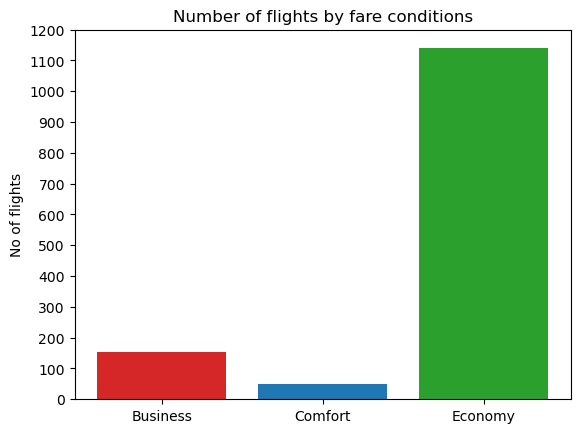

In [16]:
fare_flights = pd.read_sql('select count(*),fare_conditions from seats group by fare_conditions',con)
fig, ax = plt.subplots()
condition = fare_flights['fare_conditions']
counts = fare_flights['count(*)']
bar_labels = fare_flights['fare_conditions']

bar_colors = ['tab:red', 'tab:blue', 'tab:green']
ax.bar(condition, counts, label=bar_labels, color=bar_colors)
ax.set_ylabel('No of flights')
ax.set_title('Number of flights by fare conditions')
#I've added more tick points for claritiy of chart
range_list = [x for x in range(0,1300,100)]
ax.set(yticks=range_list)
plt.show()

## 4. Number of flights per its status 

In [28]:
# Disclaimer: Unfortunately, there is no advice, how to treat every single status. I've added just for informational purpose
%sql select f.status,count(*) [number of flights] from flights f join airports_data a1 on f.departure_airport = a1.airport_code join airports_data a2 on f.arrival_airport = a2.airport_code group by f.status

 * sqlite:///travel.sqlite
Done.


status,number of flights
Arrived,16707
Cancelled,414
Delayed,41
Departed,58
On Time,518
Scheduled,15383


## 5. Total number of sold tickets

In [29]:
%%sql select count(*) [total of tickets sold]from ticket_flights tf 
join tickets t on tf.ticket_no=t.ticket_no 
join flights f on f.flight_id=tf.flight_id 
join airports_data a1
    on f.departure_airport = a1.airport_code
  join airports_data a2
    on f.arrival_airport = a2.airport_code

 * sqlite:///travel.sqlite
Done.


total of tickets sold
1045726


## 6. Percentage of sold tickets by fare conditions

([<matplotlib.patches.Wedge at 0x209a9c23af0>,
 [Text(1.0450782316249891, 0.3432367838440191, 'Business'),
  Text(0.8646584125970608, 0.6799748741866359, 'Comfort'),
  Text(-1.0336618796845134, -0.37622216639517536, 'Economy')],
 [Text(0.5700426717954485, 0.18722006391491952, '10.1%'),
  Text(0.47163186141657854, 0.37089538591998317, '1.0%'),
  Text(-0.5638155707370072, -0.20521209076100475, '88.9%')])

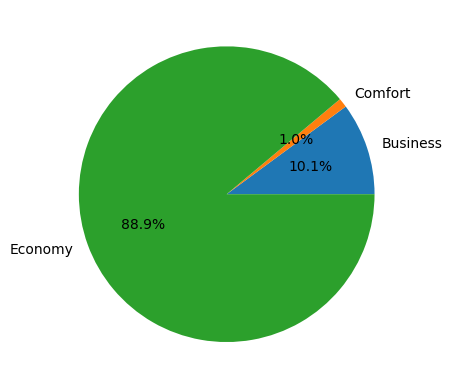

In [30]:
percent = pd.read_sql('select count(*) ,count(*) * 100 /(select count(*) from ticket_flights) percent , fare_conditions from ticket_flights group by fare_conditions',con)
percent.head(3)
labels = percent['fare_conditions']
sizes = percent['percent']
fig, ax = plt.subplots()
ax.pie(sizes, labels=labels,autopct='%1.1f%%')

## 7. Number of reservations by weekday 

In [32]:
%%sql select count(*) [number of reservations],
case cast (strftime('%w', substr(book_date,1,4) ||''|| substr(book_date,5,2)||''|| substr(book_date,7,4)) as integer)
  when 0 then 'Sunday'
  when 1 then 'Monday'
  when 2 then 'Tuesday'
  when 3 then 'Wednesday'
  when 4 then 'Thursday'
  when 5 then 'Friday'
else 'Saturday' end as weekday
from bookings 
group by 
case cast (strftime('%w', substr(book_date,1,4) ||''|| substr(book_date,5,2)||''|| substr(book_date,7,4)) as integer)
  when 0 then 'Sunday'
  when 1 then 'Monday'
  when 2 then 'Tuesday'
  when 3 then 'Wednesday'
  when 4 then 'Thursday'
  when 5 then 'Friday'
else 'Saturday' end 


 * sqlite:///travel.sqlite
Done.


number of reservations,weekday
36931,Friday
39556,Monday
37584,Saturday
39078,Sunday
35628,Thursday
39381,Tuesday
34630,Wednesday


## 9. Reservation logs (number of reservations per day)

In [33]:
%%sql select substr(book_date,1,4) ||''|| substr(book_date,5,2)||''|| substr(book_date,7,4) date,count(*) [number of reservations],
case cast (strftime('%w', substr(book_date,1,4) ||''|| substr(book_date,5,2)||''|| substr(book_date,7,4)) as integer)
  when 0 then 'Sunday'
  when 1 then 'Monday'
  when 2 then 'Tuesday'
  when 3 then 'Wednesday'
  when 4 then 'Thursday'
  when 5 then 'Friday'
else 'Saturday' end as weekday
from bookings group by substr(book_date,1,4) ||''|| substr(book_date,5,2)||''|| substr(book_date,7,4)
order by [number of reservations] desc

 * sqlite:///travel.sqlite
Done.


date,number of reservations,weekday
2017-08-14,6787,Monday
2017-08-13,6531,Sunday
2017-08-12,6350,Saturday
2017-08-11,6184,Friday
2017-08-10,6081,Thursday
2017-08-09,5937,Wednesday
2017-08-08,5813,Tuesday
2017-08-06,5761,Sunday
2017-08-05,5746,Saturday
2017-07-16,5700,Sunday


## 10. Number of day included in database 

In [34]:
%sql select count(distinct substr(book_date,1,4) ||''|| substr(book_date,5,2)||''|| substr(book_date,7,4)) [number of days] from bookings 

 * sqlite:///travel.sqlite
Done.


number of days
56


## 11.Number of departures per month

In [35]:
%%sql select count(*) [number of flights],
case 
    when scheduled_departure between '2017-09-01 00:00:00+03' and '2017-09-31 23:59:00+03' then 'September'
    when scheduled_departure between '2017-08-01 00:00:00+03' and '2017-08-31 23:59:00+03' then 'August'
    when scheduled_departure between '2017-07-01 00:00:00+03' and '2017-07-31 23:59:00+03' then 'June'
    else 'other'
end [month of departure]
from flights scheduled_departure group by [month of departure]

 * sqlite:///travel.sqlite
Done.


number of flights,month of departure
16835,August
8690,June
7596,September


## 12 Boxplot for tickets' price per fare conditions (Prices are converted from rubles to pounds onwards)

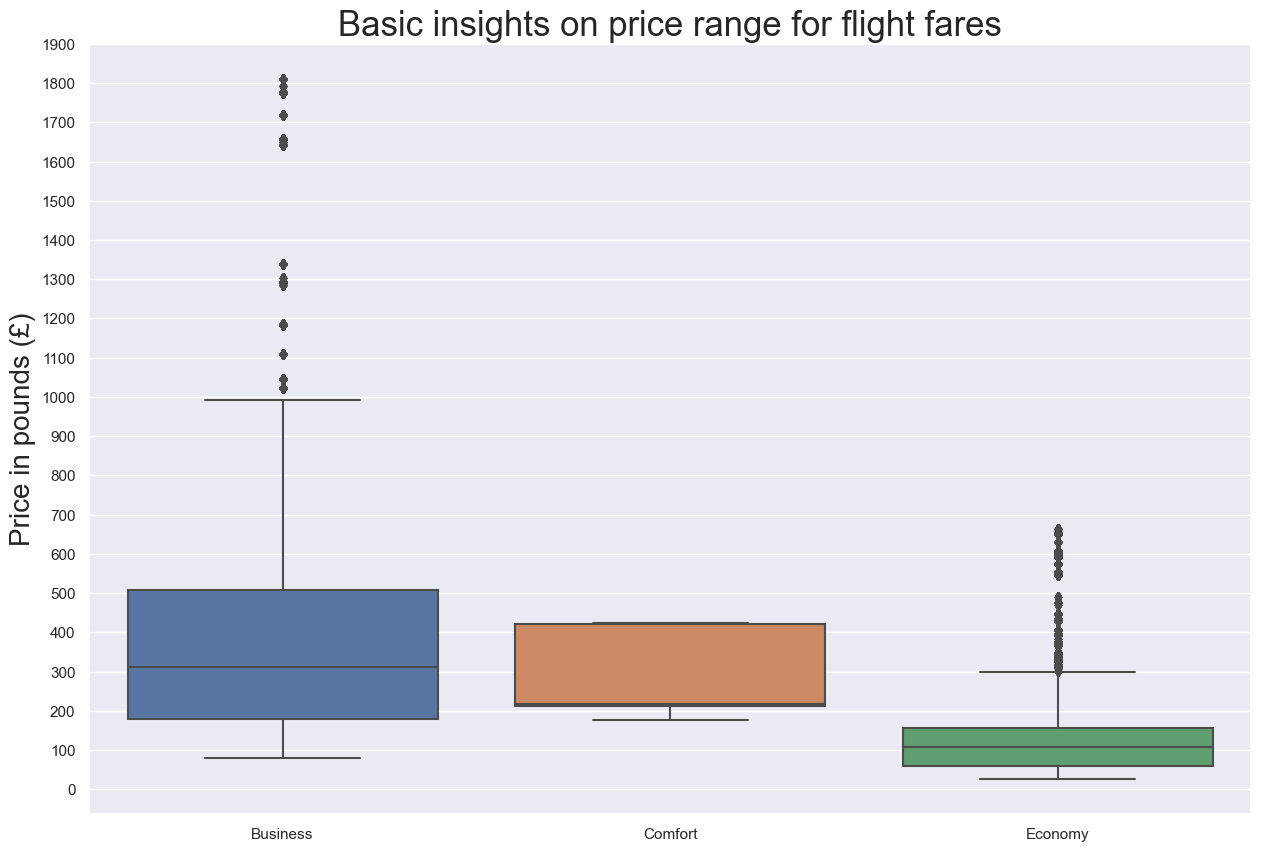

In [78]:
test = pd.read_sql('select * from ticket_flights ',con)
test['amount'] = test['amount'] * 0.0089
ax = sns.boxplot(x="fare_conditions",y="amount",data=test)
range_list = [x for x in range(0,2000,100)]
ax.set(yticks=range_list)
ax.set_ylabel('Price in pounds (£)',fontsize=20)
ax.set_xlabel('')
ax.set_title('Basic insights on price range for flight fares',fontsize=25)
sns.set(rc={'figure.figsize':(15,10)})

## 13. Top 10 flights with the highest average price

In [61]:
%%sql select round(avg(tf.amount) * 0.0085,2) [avg price], 
f.departure_airport,a1.airport_name [departure airport name], f.arrival_airport, a2.airport_name [arrival airport name] from ticket_flights tf 
join tickets t on tf.ticket_no=t.ticket_no 
join flights f on f.flight_id=tf.flight_id 
join airports_data a1
    on f.departure_airport = a1.airport_code
  join airports_data a2
    on f.arrival_airport = a2.airport_code
group by f.departure_airport,f.arrival_airport 
order by [avg price] desc limit 10

 * sqlite:///travel.sqlite
Done.


avg price,departure_airport,departure airport name,arrival_airport,arrival airport name
770.66,MRV,Mineralnyye Vody Airport,GDX,Sokol Airport
760.02,DME,Domodedovo International Airport,UUS,Yuzhno-Sakhalinsk Airport
759.91,GDX,Sokol Airport,MRV,Mineralnyye Vody Airport
753.98,SVO,Sheremetyevo International Airport,UUS,Yuzhno-Sakhalinsk Airport
752.22,UUS,Yuzhno-Sakhalinsk Airport,SVO,Sheremetyevo International Airport
751.26,DME,Domodedovo International Airport,PKC,Yelizovo Airport
749.63,PKC,Yelizovo Airport,DME,Domodedovo International Airport
748.89,UUS,Yuzhno-Sakhalinsk Airport,DME,Domodedovo International Airport
700.07,SVO,Sheremetyevo International Airport,DYR,Ugolny Airport
698.52,VKO,Vnukovo International Airport,VVO,Vladivostok International Airport


## 14. Top 10 most affordable flights with the lowest average price 

In [60]:
%%sql select round(avg(tf.amount) * 0.0085,2) [avg price], 
f.departure_airport,a1.airport_name [departure airport name], f.arrival_airport, a2.airport_name [arrival airport name] from ticket_flights tf 
join tickets t on tf.ticket_no=t.ticket_no 
join flights f on f.flight_id=tf.flight_id 
join airports_data a1
    on f.departure_airport = a1.airport_code
  join airports_data a2
    on f.arrival_airport = a2.airport_code
group by f.departure_airport,f.arrival_airport 
order by [avg price] limit 10

 * sqlite:///travel.sqlite
Done.


avg price,departure_airport,departure airport name,arrival_airport,arrival airport name
26.54,CSY,Cheboksary Airport,NBC,Begishevo Airport
26.55,NBC,Begishevo Airport,CSY,Cheboksary Airport
26.56,REN,Orenburg Central Airport,UFA,Ufa International Airport
26.56,UFA,Ufa International Airport,REN,Orenburg Central Airport
28.05,NOJ,Noyabrsk Airport,NUX,Novy Urengoy Airport
28.05,NUX,Novy Urengoy Airport,NOJ,Noyabrsk Airport
30.86,REN,Orenburg Central Airport,UUA,Bugulma Airport
30.86,UUA,Bugulma Airport,REN,Orenburg Central Airport
31.45,DME,Domodedovo International Airport,TBW,Donskoye Airport
31.45,TBW,Donskoye Airport,DME,Domodedovo International Airport


## 15. Top 10 the most popular airline routes (I've listed top 20, for instance LED-SVO and SVO-LED are treated as an one route)

In [68]:
%%sql select count(*) [no of flights] ,f.departure_airport,a1.airport_name,f.arrival_airport,a2.airport_name
  from flights f
  join airports_data a1
    on f.departure_airport = a1.airport_code
  join airports_data a2
    on f.arrival_airport = a2.airport_code
  group by f.departure_airport,a1.airport_name,f.arrival_airport,a2.airport_name
  order by [no of flights] desc limit 20


 * sqlite:///travel.sqlite
Done.


no of flights,departure_airport,airport_name,arrival_airport,airport_name_1
305,LED,Pulkovo Airport,SVO,Sheremetyevo International Airport
305,SVO,Sheremetyevo International Airport,LED,Pulkovo Airport
244,DME,Domodedovo International Airport,LED,Pulkovo Airport
244,LED,Pulkovo Airport,DME,Domodedovo International Airport
183,BZK,Bryansk Airport,DME,Domodedovo International Airport
183,BZK,Bryansk Airport,SVO,Sheremetyevo International Airport
183,BZK,Bryansk Airport,VKO,Vnukovo International Airport
183,DME,Domodedovo International Airport,BZK,Bryansk Airport
183,LED,Pulkovo Airport,VKO,Vnukovo International Airport
183,SVO,Sheremetyevo International Airport,BZK,Bryansk Airport


## 16. Total number of airports in database

In [64]:
%sql select count(*) [total no. of airports] from airports_data 


 * sqlite:///travel.sqlite
Done.


total no. of airports
104


## 17. Number of airports per continent

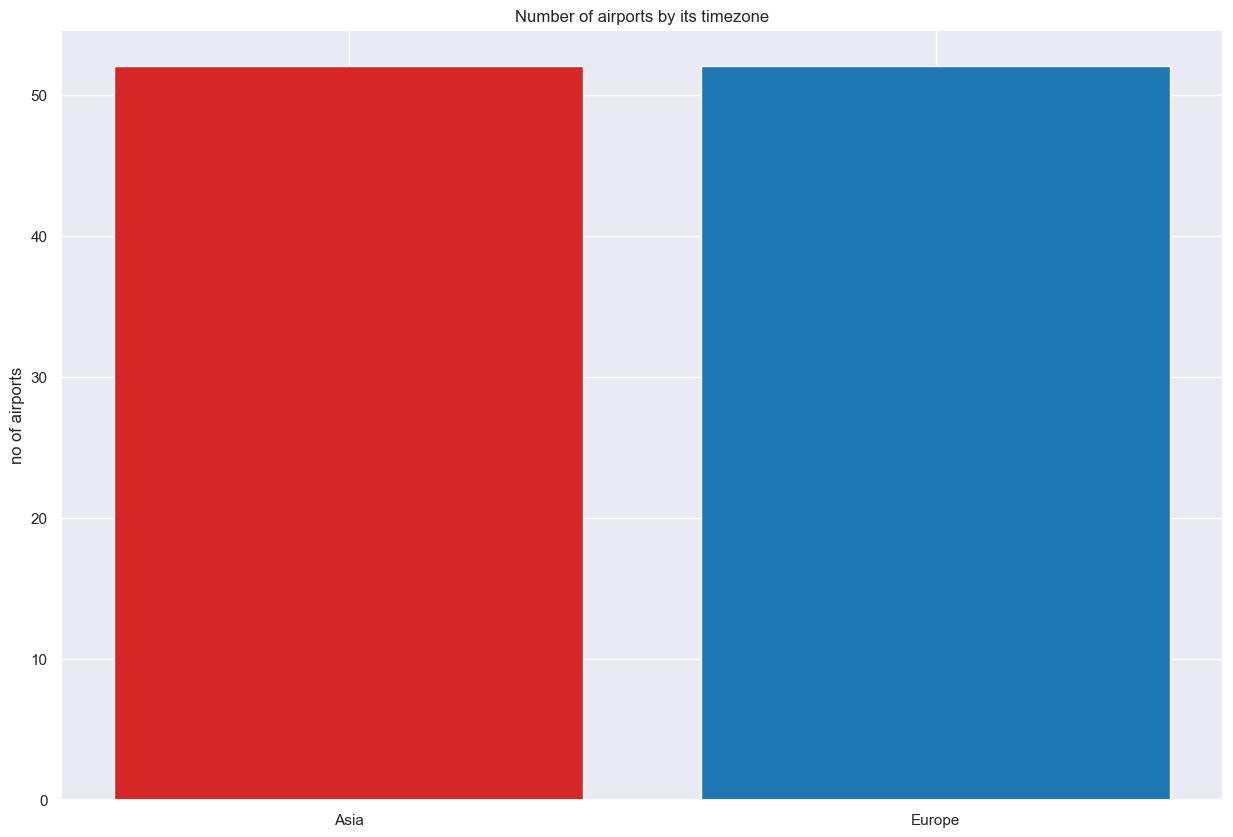

In [65]:
continents = pd.read_sql('select count(*),timezone from airports_data group by timezone',con)
#Extracting name of continent
continents['timezone'] =  [items[0:items.index('/')] for items in continents['timezone']]
continents_pd = continents.groupby(by=['timezone']).sum()
continents_pd.reset_index(inplace=True)
fig, ax = plt.subplots()
conti = continents_pd['timezone']
cnt = continents_pd['count(*)']
bar_labels = continents_pd['timezone']
bar_colors = ['tab:red', 'tab:blue']
ax.bar(conti, cnt, label=bar_labels, color=bar_colors)
ax.set_ylabel('no of airports')
ax.set_title('Number of airports by its timezone')
plt.show()

## 18. Detailed information about number of airports per specific timezone

In [66]:
%sql select count(*) [number of airports],timezone from airports_data group by timezone

 * sqlite:///travel.sqlite
Done.


number of airports,timezone
1,Asia/Anadyr
1,Asia/Chita
5,Asia/Irkutsk
1,Asia/Kamchatka
8,Asia/Krasnoyarsk
1,Asia/Magadan
2,Asia/Novokuznetsk
1,Asia/Novosibirsk
1,Asia/Omsk
1,Asia/Sakhalin


## 19. Map of airports grouped by its timezone in Folium 

In [82]:
import folium
points = pd.read_sql('select * from airports_data',con)
points['coordinates'] = points['coordinates'].str.replace(r"\(|\)", "", regex=True)
points['lon'] = [items[0:items.index(',')] for items in points['coordinates']]
points['lat'] = [items[items.index(',')+1:] for items in points['coordinates']]

latitude = points['lat']
longtitude = points['lon']
coordinates = zip(latitude,longtitude)
airport_name = points['airport_name']
timezone = points['timezone']

def icon_color(STATUS):
        if STATUS=='Asia/Yakutsk':
            return 'red'
        elif STATUS=='Asia/Vladivostok'  :
            return 'green'
        elif STATUS =='Asia/Kamchatka':
            return 'blue'
        elif STATUS == 'Asia/Sakhalin':
            return 'darkblue'
        elif STATUS == 'Europe/Moscow':
            return 'purple'
        elif STATUS =='Europe/Kaliningrad':
            return 'orange'
        elif STATUS == 'Asia/Novokuznetsk':
            return 'gray'
        elif STATUS == 'Europe/Samara':
            return 'lightred'
        elif STATUS=='Asia/Krasnoyarsk'  :
            return 'lightblue'
        elif STATUS =='Asia/Irkutsk':
            return 'cadetblue'
        elif STATUS == 'Europe/Volgograd':
            return 'beige'
        elif STATUS == 'Asia/Anadyr':
            return 'black'
        elif STATUS == 'Asia/Novosibirsk':
            return 'lightgray'
        elif STATUS == 'Asia/Omsk':
            return 'white'
        elif STATUS == 'Asia/Magadan':
            return 'darkpurple'
        elif STATUS == 'Asia/Chita':
            return 'darkgreen'
        elif STATUS == 'Asia/Yekaterinburg':
            return 'pink'

airport_map = folium.Map( location=[55.751244, 37.618423], zoom_start=4 )
for i in range(0,len(points)):
     Location=[points.iloc[i]['lat'],points.iloc[i]['lon']]
     Popup=points.iloc[i]['airport_name'] + ' Timezone: ' + points.iloc[i]['timezone']
     ic=icon_color(points.iloc[i]['timezone'])
     folium.Marker( location=Location, radius=8, popup=Popup,icon=folium.Icon(color=ic, icon='plane',prefix='fa'),fill=True).add_to(airport_map)

airport_map.save( 'map.html')

In [83]:
display(airport_map)
